# Формальные штуки (git clone, pull, commit)

In [ ]:
!git clone https://github.com/sofiyabogakovskaya/HopfieldAM.git

Cloning into 'HopfieldAM'...
remote: Enumerating objects: 496, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 496 (delta 67), reused 107 (delta 35), pack-reused 349 (from 1)
Receiving objects: 100% (496/496), 4.20 MiB | 15.15 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [ ]:
%%bash
git config --global user.name "sofiyabogakovskaya"
git config --global user.email "s.bogakovskaya@gmail.com"

In [ ]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# commiting

%%bash
# cd HopfieldAM/ #cd = change directory
git add .
git commit -m "cosmetic changes" #-m -- message
git push origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


CalledProcessError: Command 'b'# cd HopfieldAM/ #cd = change directory\ngit add .\ngit commit -m "cosmetic changes" #-m -- message\ngit push origin main\n'' returned non-zero exit status 128.

In [ ]:
!mkdir "HopfieldAM/src" #create the folder

In [ ]:
!rm -rf "HopfieldAM/src" #remove the folder

In [ ]:
!touch "HopfieldAM/.project-root"

---

In [ ]:
!touch "./src/Hopfield_model"

touch: cannot touch './src/Hopfield_model': No such file or directory


In [ ]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 361 bytes | 361.00 KiB/s, done.
From https://github.com/sofiyabogakovskaya/HopfieldAM
   74f6cef..ac6a7a9  main       -> origin/main
Updating 74f6cef..ac6a7a9
Fast-forward
 datasets/get_dimension.py | 7 +++++--
 1 file changed, 5 insertions(+), 2 deletions(-)


---
# Install the requirements

In [ ]:
!pip install -r HopfieldAM/requirements.txt
# !pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 6.2 MB/s eta 0:00:00


# Create root

In [ ]:
!pip install rootutils

!touch /content/HopfieldAM/.project-root

import os
import rootutils

rootutils.setup_root(os.path.abspath('/content/HopfieldAM'), indicator=".project-root", pythonpath=True, dotenv=True, cwd=True)

PosixPath('/content/HopfieldAM')

In [ ]:
!pwd

/content/HopfieldAM


In [ ]:
#autoreload -- чтобы сохранять изменения в ноутбуке asap. у меня не работает правда

%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

---
# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Get results.log from drive:

In [ ]:
import shutil

DRIVE_RESULTS_LOG = '/content/drive/MyDrive/HopfieldAM_experiments/experiments/results.log'
LOCAL_RESULTS_LOG = 'experiments/results.log'
os.makedirs(os.path.dirname(LOCAL_RESULTS_LOG), exist_ok=True)

# pull existing log
if os.path.exists(DRIVE_RESULTS_LOG):
    shutil.copy(DRIVE_RESULTS_LOG, LOCAL_RESULTS_LOG)
else:
    open(LOCAL_RESULTS_LOG, 'a').close()

---
# Делаем импорты, скачиваем данные

In [ ]:
import shutil
from argparse import Namespace

import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
from jax import vmap
from jax.nn import relu, sigmoid, gelu, softplus, silu

import equinox as eqx
import optax


from utils.config import CONFIG
from utils.activation_map import ACTIVATION_MAP
from models import get_model
from losses import get_batch_loss
from datasets.dataset_loader import get_dataloader
from datasets.get_dimension import get_dimension
from src.train import train
from src.test import test
from utils.visualization import plot_metrics, plot_energy
from utils.integrate_trajectory import integrate_trajectory, get_energy
from utils.logger import new_run_id, log_experiment, log_summary
from utils.parse_config import parse_config

/content/HopfieldAM/models/Hopfield.py:14: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  g: Callable = eqx.static_field()


Здесь определяется `config`!

In [ ]:
args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    activation = "relu",
    epochs=5,
    batch_size=128,
    learning_rate=1e-3,
    dt=5e-2,
    t1=5.0,
    N_classes=10,
)

config=vars(args)

In [ ]:
# dataset options: mnist fashion_mnist, cifar10, omniglot

In [ ]:
train_loader, val_loader, test_loader = get_dataloader(dataset_name=args.dataset_name, batch_size=args.batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.9I9SI5_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.9I9SI5_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


---
# Обучение

In [ ]:
from jax.nn import relu, sigmoid, tanh, silu, gelu, softplus

ACTIVATION_MAP = {
    "relu": relu,
    "sigmoid": sigmoid,
    "tanh": tanh,
    "silu": silu,
    "gelu": gelu,
    "softplus": softplus
}

In [ ]:
run_id = new_run_id()

N_neurons = get_dimension(args.dataset_name)
key = random.PRNGKey(19)
g = ACTIVATION_MAP[args.activation]
model = get_model(args.model, key=key, N_neurons=N_neurons, g=g)

batch_loss = get_batch_loss(args.loss)
optimizer = optax.adam(learning_rate=args.learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

In [ ]:
@eqx.filter_jit
def update(model, x, y, batch_loss, opt_state, optimizer, dt, t1, N_classes):
    loss, grads = eqx.filter_value_and_grad(batch_loss)(model, x, y, dt, t1, N_classes)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

def train(model,
          train_loader,
          val_loader,
          batch_loss,
          optimizer,
          opt_state,
          epochs,
          dt,
          t1,
          N_classes):

    train_losses = []
    val_accuracies = []
    for epoch in tqdm(range(epochs), desc="epoch training..."):
        total_loss = 0.0
        num_batches = 0
        for x_batch, y_batch in train_loader():
            model, opt_state, loss_value = update(model=model,
                                                  x=x_batch,
                                                  y=y_batch,
                                                  batch_loss=batch_loss,
                                                  opt_state=opt_state,
                                                  optimizer=optimizer,
                                                  dt=dt,
                                                  t1=t1,
                                                  N_classes=N_classes
                                                  )
            total_loss += loss_value
            num_batches += 1
        train_loss = total_loss / num_batches
        train_loss = round(float(train_loss), 4)
        val_accuracy = batch_accuracy(model, val_loader, dt, t1, N_classes)
        val_accuracy = round(float(val_accuracy), 4)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.2%}")
        # log_message(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Accuracy: {val_acc:.2%}")
        # log_metrics({"epoch": epoch + 1, "loss": float(avg_loss), "val_accuracy": float(val_acc)})

        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)

    return model, train_losses, val_accuracies

In [ ]:
run_id = new_run_id()

N_neurons = get_dimension(args.dataset_name)
key = random.PRNGKey(19)
g = ACTIVATION_MAP[args.activation]
model = get_model(args.model, key=key, N_neurons=N_neurons, g=g)

batch_loss = get_batch_loss(args.loss)
optimizer = optax.adam(learning_rate=args.learning_rate)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

trained_model, train_losses, val_accuracies = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        batch_loss=batch_loss,
        optimizer=optimizer,
        opt_state=opt_state,
        epochs=args.epochs,
        dt=args.dt,
        t1=args.t1,
        N_classes=args.N_classes
        )

test_loss, test_accuracy = test(trained_model, test_loader, batch_loss, args.dt, args.t1, args.N_classes)

metrics = {
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
        }

log_experiment(run_id, trained_model, opt_state, config, metrics)
log_summary(run_id, config, metrics)
plot_metrics(run_id)

X_batch, y_batch = next(train_loader())
samples = 10
plot_energy(run_id, trained_model, X_batch, y_batch, args.dt, args.t1, samples)
plot_energy2(run_id, trained_model, X_batch, y_batch, args.dt, args.t1, samples)

src = f"experiments/{run_id}"
dst = f"/content/drive/MyDrive/HopfieldAM_experiments/experiments/{run_id}"
shutil.copytree(src, dst, dirs_exist_ok=True)
shutil.copy(LOCAL_RESULTS_LOG, DRIVE_RESULTS_LOG)

epoch training...:   0%|          | 0/5 [00:00<?, ?it/s]

# Логаем метрики

Plot saved to experiments/run_20250514_133215/training_plot.png


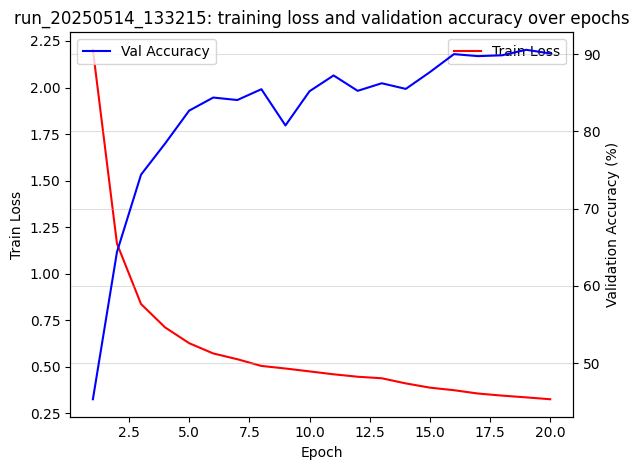

In [ ]:
metrics = {
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
        }

log_experiment(run_id, trained_model, opt_state, config, metrics)
log_summary(run_id, config, metrics)
plot_metrics(run_id)

Plot saved to experiments/run_20250514_133215/energy_plot_10samples.png


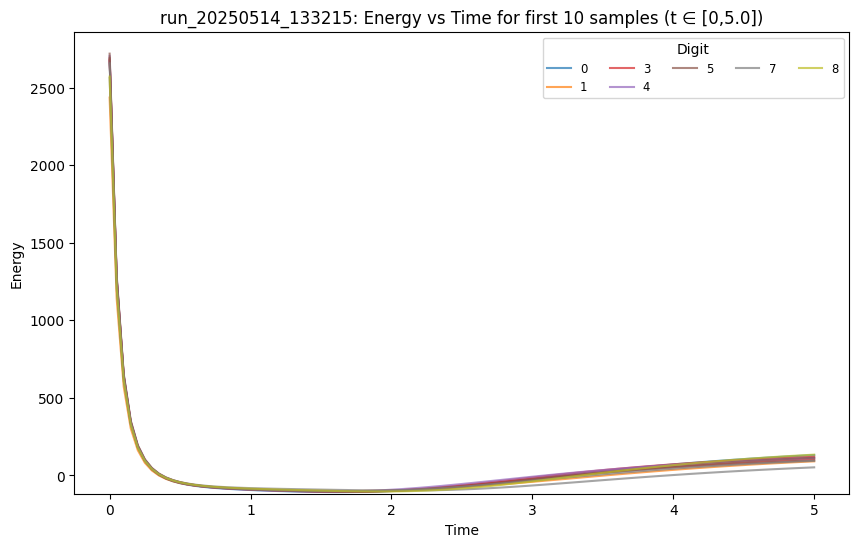

In [ ]:
X_batch, y_batch = next(train_loader())
samples = 10
plot_energy(run_id, trained_model, X_batch, y_batch, args.dt, args.t1, samples)

In [ ]:
src = f"experiments/{run_id}"
dst = f"/content/drive/MyDrive/HopfieldAM_experiments/experiments/{run_id}"
shutil.copytree(src, dst, dirs_exist_ok=True)
shutil.copy(LOCAL_RESULTS_LOG, DRIVE_RESULTS_LOG)

'/content/drive/MyDrive/HopfieldAM_experiments/experiments/results.log'

# Inference stage

In [ ]:
import shutil
from argparse import Namespace

import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
import jax

import equinox as eqx
import optax
import numpy as np

import tensorflow_datasets as tfds


from models import get_model
from losses import get_batch_loss
from datasets.dataset_loader import get_dataloader
from datasets.get_dimension import get_dimension
from src.train import train
from src.test import test
from utils.visualization import plot_metrics, create_batch_to_compute_energy, plot_energy, plot_energy_dot
from utils.integrate_trajectory import integrate_trajectory, get_energy
from utils.logger import new_run_id, log_experiment, log_summary
from utils.parse_config import parse_config
from utils.config import CONFIG
from utils.activation_map import ACTIVATION_MAP
from utils.for_inference import get_best_checkpoint_path, load_best_model


from tqdm.auto import tqdm
import os
import glob
import re

/content/HopfieldAM/models/Hopfield.py:14: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  g: Callable = eqx.static_field()


In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-3"

In [ ]:
args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,

    activation = "relu",
    dt=0.01,
    t1=5.0,

    N_classes=10,
)

best_model = load_best_model(
    args,
    experiments_dir=experiments_dir)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.LW88K5_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.LW88K5_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
X, y = create_batch_to_compute_energy(
    numbers=[0, 1],
    each_number_samples=1,
    dataset_name=args.dataset_name,
    split="test"
)
samples = y.shape[0]

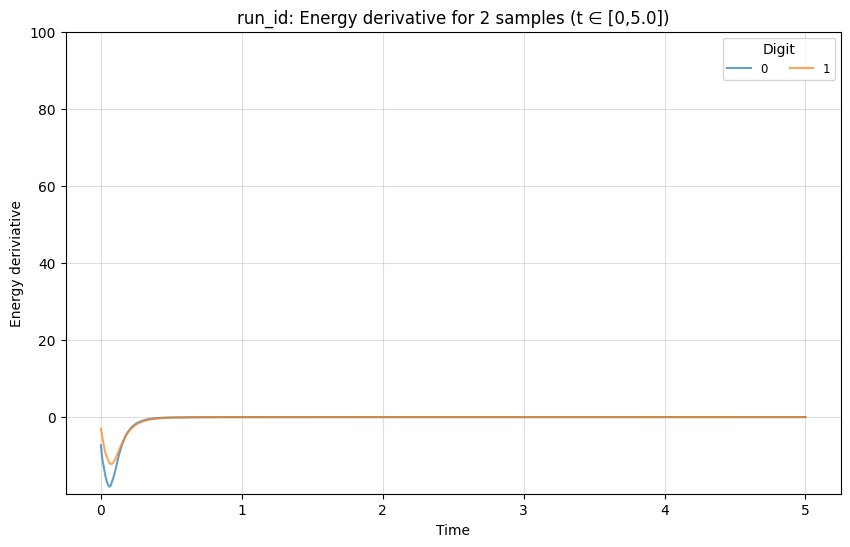

In [ ]:
plot_energy_dot("run_id", best_model, X, y, args.dt, args.t1, samples, save_plot=False)

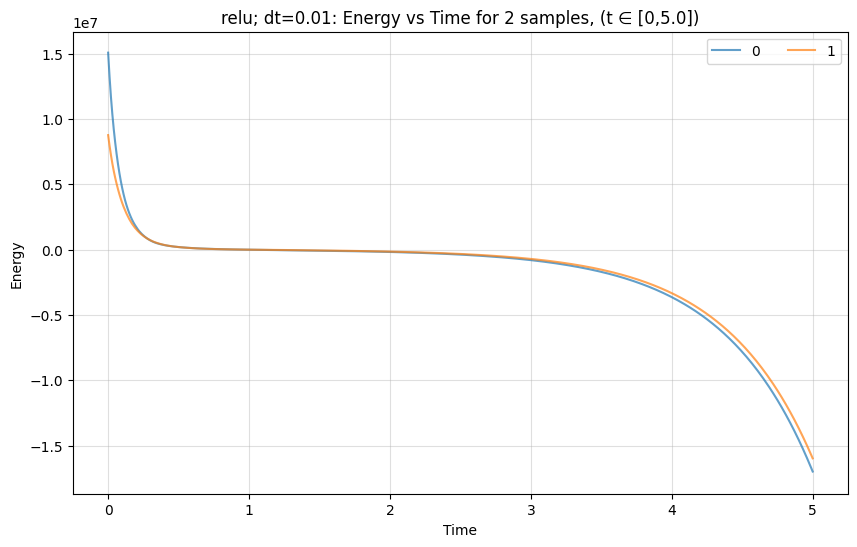

In [ ]:
plot_energy(
    f"{args.activation}; dt={args.dt}",
    best_model,
    X,
    y,
    args.dt,
    args.t1,
    samples,
    save_plot=False,
    # ylim=(330, 370),
    # xlim=(10, 15.5),
    plot_only_mean=False
)